In [ ]:
from duckduckgo_search import DDGS  #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=100): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

urls = search_images("bear images", max_images=1)
urls[0]

dest = "bear.jpg"
download_url(urls[0], dest)

im = Image.open(dest)
im.to_thumb(256, 256)

In [10]:
from time import sleep

searches = "polar", "grizzly", "black", "red"
path = Path("bears_type")

for o in searches:
    dest = (path / o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear photo'))
    sleep(15)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} bear sun photo'))
    sleep(15)
    download_images(dest, urls=search_images(f'{o} bear shade photo'))
    sleep(15)
    resize_images(path / o, max_size=400, dest=path / o) 

/home/anubhav-auth/miniconda3/envs/ml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubhav-auth/miniconda3/envs/ml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubhav-auth/miniconda3/envs/ml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubhav-auth/miniconda3/envs/ml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubhav-auth/miniconda3/envs/ml_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be convert

158


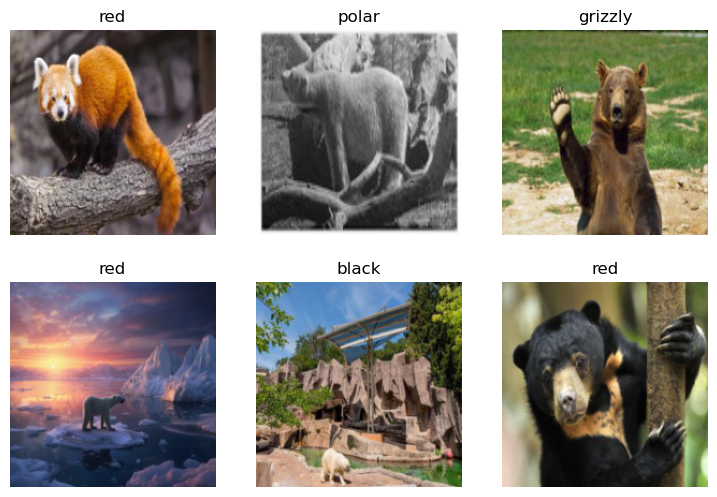

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(len(failed))

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [15]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.644052,0.967212,0.280000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.923323,0.863707,0.287500,00:10
1,0.769997,0.902106,0.290000,00:10
2,0.657656,0.942560,0.275000,00:10
3,0.577259,1.144521,0.287500,00:10
4,0.532787,1.128677,0.290000,00:10
5,0.496240,1.087589,0.275000,00:10
6,0.464909,1.177265,0.270000,00:10
7,0.423561,1.145213,0.282500,00:10
8,0.382263,1.162068,0.270000,00:10
9,0.346052,1.171121,0.267500,00:10


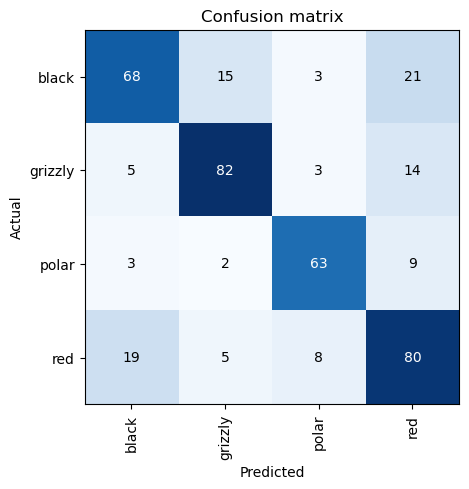

In [16]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix() #this tells how many if any are wrong ex:- 5grizzly bear images were predicted as black bear 3 as polar and 14 as red this says that differentiating btw grizzly and red is diff

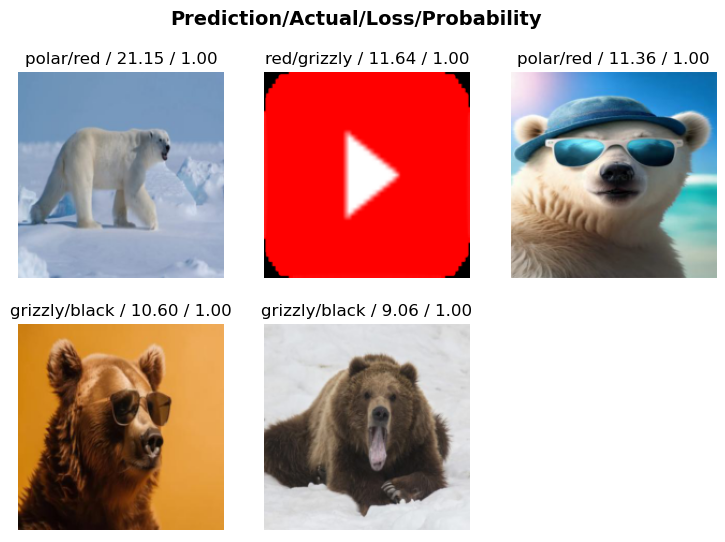

In [18]:
interp.plot_top_losses(5) ##this shows where we went wrong

In [22]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learner)
cleaner # you get the option to choose what a image belong to like choose red bear and train you get the training set for red bears if you see a grizzly bear in it you can mark it as grizzly or if its something else entirely you can delete it

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() ##removes the image we set to delete
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) ##the ones we changed move them to new folder